In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load data
df = pd.read_csv(r'C:\Users\dinhn\Downloads\Ethereum_Historical_Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Function to create dataset for time series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step
time_step = 10

# Split data into train and test sets
train_size = int(0.6 * len(data_scaled))
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

# Create dataset for training and testing
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

Epoch 1/100
36/36 [==============================] - 4s 10ms/step - loss: 0.0144
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 3/100
36/36 [==============================] - 0s 9ms/step - loss: 8.4140e-04
Epoch 4/100
36/36 [==============================] - 0s 10ms/step - loss: 8.3457e-04
Epoch 5/100
36/36 [==============================] - 0s 11ms/step - loss: 8.0340e-04
Epoch 6/100
36/36 [==============================] - 0s 10ms/step - loss: 7.7055e-04
Epoch 7/100
36/36 [==============================] - 0s 10ms/step - loss: 7.6063e-04
Epoch 8/100
36/36 [==============================] - 0s 9ms/step - loss: 6.8476e-04
Epoch 9/100
36/36 [==============================] - 0s 9ms/step - loss: 6.8378e-04
Epoch 10/100
36/36 [==============================] - 0s 9ms/step - loss: 6.8342e-04
Epoch 11/100
36/36 [==============================] - 0s 9ms/step - loss: 6.6908e-04
Epoch 12/100
36/36 [==============================] - 0s 9ms/step - loss: 5.

<h2> Predict Price for next 30 days </h2>

Predicted Ethereum prices for the next 30 days:
[3845.21286076 3876.40199455 3907.84664379 3939.19547474 3970.28402735
 4001.08288372 4031.5508588  4061.63724174 4091.30729141 4120.53551229
 4149.31293894 4177.62416197 4205.45377201 4232.79168293 4259.62528706
 4285.94449825 4311.74147175 4337.0080826  4361.73732655 4385.92303984
 4409.56158026 4432.64986593 4455.18593567 4477.16810844 4498.59470324
 4519.46880192 4539.78956398 4559.56119198 4578.78648762 4597.4682526 ]


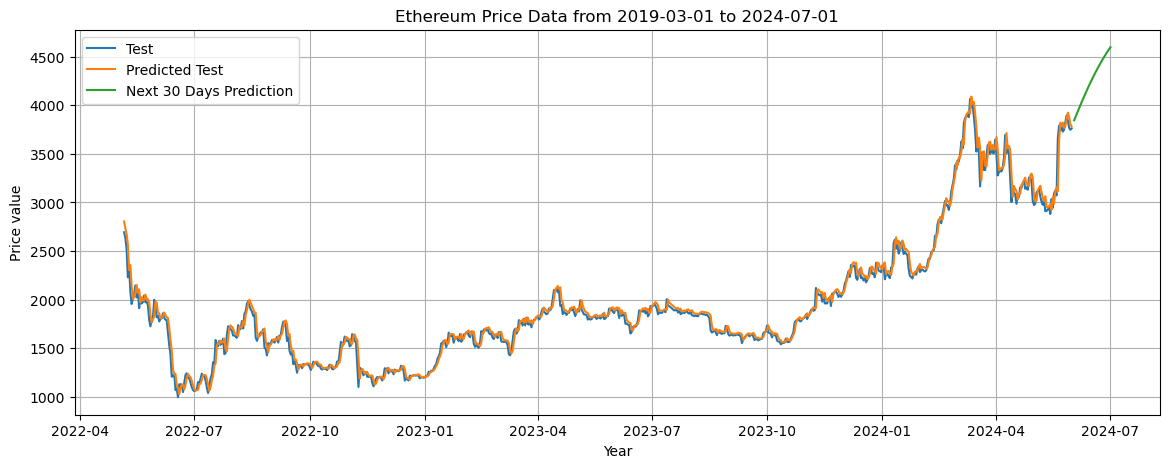

In [5]:
# The process of creating index to predict the next 90 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 90 days
lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_30_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 90 days
print('Predicted Ethereum prices for the next 30 days:')
print(y_next_30_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_30_days, y_next_30_days, label='Next 30 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predicted Price for next 60 days


Predicted Ethereum prices for the next 60 days:
[3845.21286076 3876.40199455 3907.84664379 3939.19547474 3970.28402735
 4001.08288372 4031.5508588  4061.63724174 4091.30729141 4120.53551229
 4149.31293894 4177.62416197 4205.45377201 4232.79168293 4259.62528706
 4285.94449825 4311.74147175 4337.0080826  4361.73732655 4385.92303984
 4409.56158026 4432.64986593 4455.18593567 4477.16810844 4498.59470324
 4519.46880192 4539.78956398 4559.56119198 4578.78648762 4597.4682526
 4615.61405153 4633.22668612 4650.31400112 4666.88244047 4682.93872826
 4698.49126959 4713.54762907 4728.11817301 4742.21074617 4755.83515453
 4769.00176439 4781.71898087 4793.99885128 4805.84950058 4817.2838166
 4828.31020447 4838.94099167 4849.18458332 4859.05330692 4868.55724861
 4877.70705486 4886.51281181 4894.98516594 4903.13476372 4910.97169128
 4918.50547443 4925.7461993  4932.70339169 4939.38601704 4945.80472183]


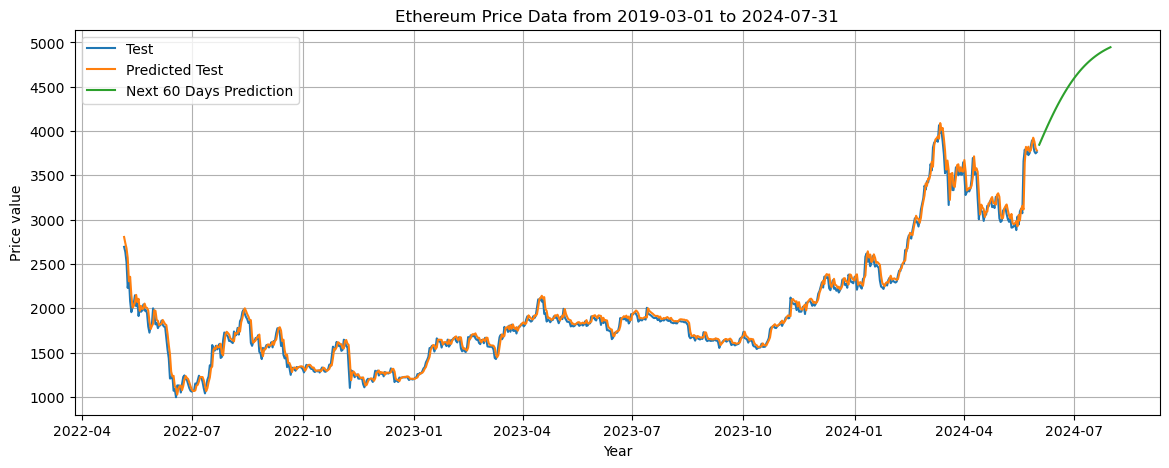

In [3]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 60):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_60_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted Ethereum prices for the next 60 days:')
print(y_next_60_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_60_days, y_next_60_days, label='Next 60 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predict Price for the next 90 days </h2>

Predicted Ethereum prices for the next 90 days:
[3845.21286076 3876.40199455 3907.84664379 3939.19547474 3970.28402735
 4001.08288372 4031.5508588  4061.63724174 4091.30729141 4120.53551229
 4149.31293894 4177.62416197 4205.45377201 4232.79168293 4259.62528706
 4285.94449825 4311.74147175 4337.0080826  4361.73732655 4385.92303984
 4409.56158026 4432.64986593 4455.18593567 4477.16810844 4498.59470324
 4519.46880192 4539.78956398 4559.56119198 4578.78648762 4597.4682526
 4615.61405153 4633.22668612 4650.31400112 4666.88244047 4682.93872826
 4698.49126959 4713.54762907 4728.11817301 4742.21074617 4755.83515453
 4769.00176439 4781.71898087 4793.99885128 4805.84950058 4817.2838166
 4828.31020447 4838.94099167 4849.18458332 4859.05330692 4868.55724861
 4877.70705486 4886.51281181 4894.98516594 4903.13476372 4910.97169128
 4918.50547443 4925.7461993  4932.70339169 4939.38601704 4945.80472183
 4951.96735085 4957.88455055 4963.56360538 4969.01236012 4974.23921986
 4979.25427074 4984.06367653 49

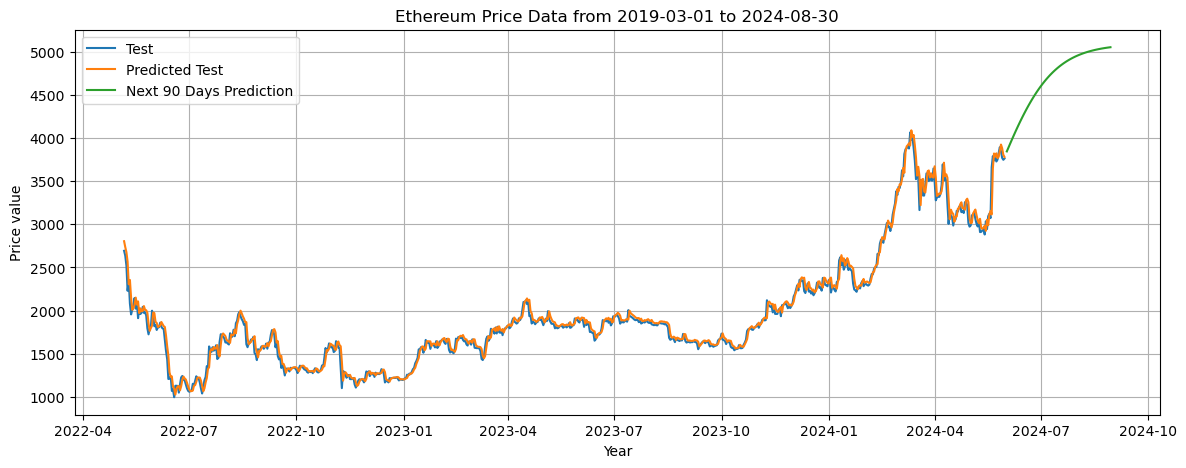

In [4]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 90):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_90_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted Ethereum prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_90_days, y_next_90_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()